----- starting point of Episode 0 in steps 0 loop -----
Physical Action for Agent 0 from problem solver: 2
Physical Action for Agent 1 from problem solver: 0
agent 0 is ongoing!
win status agent 0 = False
agent 1 is ongoing!
win status agent 1 = False
wins all agent situation in the environment: [False, False]
comm next state for agent 0: 0
action type of agent: 0: problem solver, agent learned
comm next state for agent 1: 0
action type of agent: 1: problem solver, agent learned
----- starting point of Episode 0 in steps 1 loop -----
Physical Action for Agent 0 from problem solver: 3
Physical Action for Agent 1 from problem solver: 3
agent 0 is ongoing!
win status agent 0 = False
agent 1 is ongoing!
win status agent 1 = False
wins all agent situation in the environment: [False, False]
comm next state for agent 0: 0
action type of agent: 0: problem solver, agent learned
comm next state for agent 1: 0
action type of agent: 1: problem solver, agent learned
----- starting point of Episode 

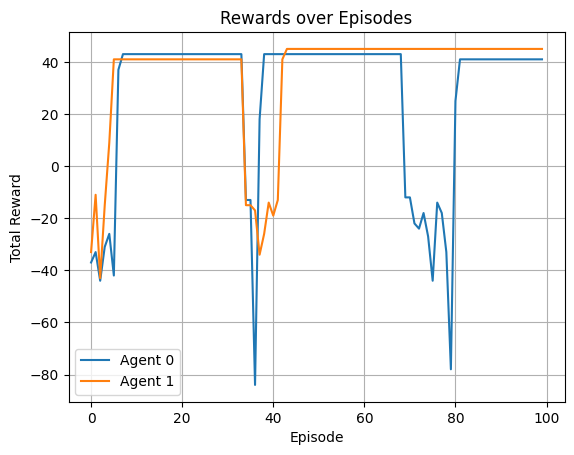

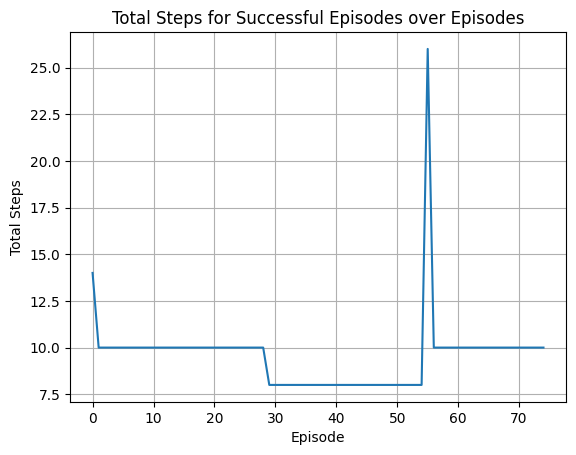

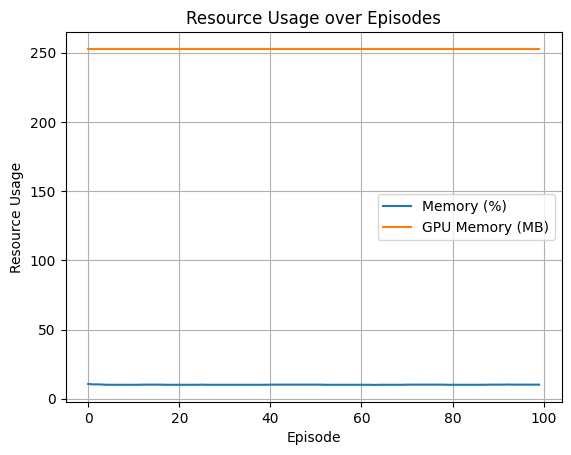

In [1]:
import numpy as np
import random
from collections import defaultdict
import ast
import json
import psutil
import pynvml
import matplotlib.pyplot as plt

from environment_ma_reward_distance_dynamic_notrandom import Env


def learn(self, agent_idx, state, action, reward, next_state, case_base=None):
        state = tuple(state)
        next_state = tuple(next_state)
        current_q = self.q_tables[agent_idx][state][action]
        max_next_q = max(self.q_tables[agent_idx][next_state])

        # Calculate the Q-update with weighted distance-based pull reward if case_base exists
        if case_base:
            print(f"Calculating weighted distance-based pull reward for agent {agent_idx}")
            pull_reward = 0  # Initialize pull reward
            
            for case in case_base:
                problems = case.problem if isinstance(case.problem, list) else [case.problem]
                
                weight = case.trust_value
                
                # Calculate the pull reward based on the weighted difference in distances
                for p in problems:
                    distance_current = np.linalg.norm(np.array(state) - np.array(p))
                    distance_next = np.linalg.norm(np.array(next_state) - np.array(p))

                    distance_diff = distance_current - distance_next
                    distance_diff = weight * distance_diff
                    pull_reward += np.log1p(abs(distance_diff)) * np.sign(distance_diff)
                    pull_reward = np.clip(pull_reward, -1 * self.epsilon, self.epsilon)
                    # pull_reward = np.clip(pull_reward, -0.1, 0.1) 
            
            print(f"Calculating pull reward agent {agent_idx}: from state {state} with action {action} to next state {next_state}: pull reward: {pull_reward}")
            new_q = current_q + self.learning_rate * (reward + pull_reward + self.discount_factor * max_next_q - current_q)
        else:
            # Standard Q-learning update without pull reward
            print(f"No communication. Standard Q-learning update for agent {agent_idx}")
            new_q = current_q + self.learning_rate * (reward + self.discount_factor * max_next_q - current_q)

        self.q_tables[agent_idx][state][action] = new_q

class ProblemSolver:
    def __init__(self, num_actions, env, alpha, gamma, epsilon):
        self.env = env
        self.num_actions = num_actions
        self.learning_rate = alpha
        self.discount_factor = gamma
        self.epsilon = epsilon
        self.q_tables = [defaultdict(lambda: [0.0] * num_actions) for _ in range(env.num_agents)]

    @staticmethod
    def arg_max(state_action):
        max_index_list = []
        max_value = state_action[0]
        for index, value in enumerate(state_action):
            if value > max_value:
                max_index_list.clear()
                max_value = value
                max_index_list.append(index)
            elif value == max_value:
                max_index_list.append(index)
        return random.choice(max_index_list)

    def choose_action(self, agent_idx, state):
        state = tuple(state)
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.num_actions)
        else:
            state_action = self.q_tables[agent_idx][state]
            action = self.arg_max(state_action)
        return action

    def learn(self, agent_idx, state, action, reward, next_state):
        state = tuple(state)
        next_state = tuple(next_state)
        current_q = self.q_tables[agent_idx][state][action]
        max_next_q = max(self.q_tables[agent_idx][next_state])
        new_q = current_q + self.learning_rate * (reward + self.discount_factor * max_next_q - current_q)
        self.q_tables[agent_idx][state][action] = new_q

    def adjust_q_for_successful_path(self, agent_idx, state, action, successful_path, distance_threshold=2):
        """
        Adjust Q-values based on the successful path of another agent.
        This provides a 'pull' effect towards the successful path.
        """
        state = tuple(state)
        current_q = self.q_tables[agent_idx][state][action]

        # Calculate distance from current state to each state in the successful path
        for path_state in successful_path:
            path_state = tuple(path_state)
            distance = np.linalg.norm(np.array(state) - np.array(path_state))

            if distance <= distance_threshold:
                # Closer states get a higher 'pull' reward
                pull_reward = 1 / (distance + 1e-5)  # Prevent division by zero
                new_q = current_q + self.learning_rate * (pull_reward - current_q)
                self.q_tables[agent_idx][state][action] = new_q


class Case:

    def __init__(self, problem, solution, trust_value=0.5, total_time_steps=0, path=None):
        self.problem = ast.literal_eval(problem) if isinstance(problem, str) else problem
        self.solution = solution
        self.trust_value = trust_value
        self.total_time_steps = total_time_steps  # New attribute for total time steps
        self.path = path  # New attribute to store the path

    @staticmethod
    def sim_q(state1, state2):
        state1 = np.atleast_1d(state1)
        state2 = np.atleast_1d(state2)
        CNDMaxDist = 6
        v = state1.size
        DistQ = np.sum([Case.dist_q(Objic, Objip) for Objic, Objip in zip(state1, state2)])
        similarity = (CNDMaxDist * v - DistQ) / (CNDMaxDist * v)
        return similarity

    @staticmethod
    def dist_q(X1, X2):
        return np.min(np.abs(X1 - X2))

    @staticmethod
    def retrieve(state, case_base, threshold=0.1):
        state = ast.literal_eval(state) if isinstance(state, str) else state
        for case in case_base:
            if state == case.problem: 
                return case

    @staticmethod
    def reuse(agent_idx, c, own_temp_case_base, comm_temp_case_base, source='own'):
        """Reuse step for adding cases to temporary case bases."""
        if source == 'own':
            own_temp_case_base.append(c)
        elif source == 'comm':
            comm_temp_case_base.append(c)

    @staticmethod
    def revise(agent_idx, case_base, temporary_case_base, successful_episodes):
        for case in case_base:
            if any((case.problem, case.solution) == (temp_case.problem, temp_case.solution) for temp_case in temporary_case_base):
                if successful_episodes:
                    case.trust_value += 0.1
                else:
                    case.trust_value -= 0.4
            else:
                if successful_episodes:
                    case.trust_value -= 0.4
            
            case.trust_value = max(0, min(case.trust_value, 1))
            print(f"case content after REVISE for agent {agent_idx}, problem: {case.problem}, solution: {case.solution}, tv: {case.trust_value}, time steps: {case.total_time_steps}")

    @staticmethod
    def retain(agent_idx, case_base, own_temp_case_base, comm_temp_case_base, successful_episodes, threshold=0.49):

        if successful_episodes:
            for temp_case in reversed(own_temp_case_base):
                state = tuple(np.atleast_1d(temp_case.problem))
    
                if not any(tuple(np.atleast_1d(case.problem)) == state for case in case_base):
                    case_base.append(temp_case)
                    print(f"Episode succeeded, case {temp_case.problem} is empty. Temporary case base stored to the case base: {temp_case.problem, temp_case.solution, temp_case.trust_value}")         
                else:
                    print(f"Episode succeeded, case {temp_case.problem} for agent {agent_idx} is not empty. Temporary case base that not stored to the case base: {temp_case.problem, temp_case.solution, temp_case.trust_value}")    
        else:
            print(f"Episode not succeeded, temporary case base from own experience is not stored to the case base")
        
        case_base_dict = {tuple(np.atleast_1d(case.problem)): case for case in case_base}

        for temp_comm_case in reversed(comm_temp_case_base):
            state_comm = tuple(np.atleast_1d(temp_comm_case.problem))
            
            existing_case = case_base_dict.get(state_comm) 

            if existing_case is None:
                case_base.append(temp_comm_case)
                case_base_dict[state_comm] = temp_comm_case 
                print(f"Integrated case process. comm case {temp_comm_case.problem} is empty. Temporary case base stored to the case base: {temp_comm_case.problem, temp_comm_case.solution, temp_comm_case.trust_value}")         
            # elif existing_case.trust_value < temp_comm_case.trust_value:
            #     existing_case.solution = temp_comm_case.solution
            #     existing_case.trust_value = max(0, temp_comm_case.trust_value)
            #     print(f"Integrated case process. Similar comm case for agent {agent_idx} is found. Updated case base with higher trust value: {temp_comm_case.problem, temp_comm_case.solution, temp_comm_case.trust_value}")
            # else:
            #     print(f"Integrated case process. comm case {temp_comm_case.problem} for agent {agent_idx} is not empty. Temporary case base that not stored to the case base: {temp_comm_case.problem, temp_comm_case.solution, temp_comm_case.trust_value}")   

        # Apply 'pull' effect: Adjust Q-values based on successful path
        for comm_case in comm_temp_case_base:
            if comm_case.trust_value >= threshold and comm_case.path is not None:
                successful_path = comm_case.path
                for state, action in QCBRL.get_states_actions_near_path(agent_idx, successful_path):
                    agent.problem_solvers[agent_idx].adjust_q_for_successful_path(agent_idx, state, action, successful_path)

        case_base[:] = [case for case in case_base if case.trust_value >= threshold]

        for case in case_base:
            print(f"cases content after RETAIN, problem: {case.problem}, solution: {case.solution}, tv: {case.trust_value}")

        return case_base


class QCBRL:
    def __init__(self, num_actions, env, episodes, max_steps, alpha, gamma, epsilon, epsilon_decay, epsilon_min, render):
        self.num_actions = num_actions
        self.env = env
        self.episodes = episodes
        self.max_steps = max_steps
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.render = render
        self.epsilon_decay = epsilon_decay  
        self.epsilon_min = epsilon_min  

        self.problem_solvers = [ProblemSolver(num_actions, self.env, alpha, gamma, epsilon) for _ in range(self.env.num_agents)]
        self.case_bases = [[] for _ in range(self.env.num_agents)]  # Individual case bases for each agent
        self.own_temp_case_bases = [[] for _ in range(self.env.num_agents)]  # Temporary case bases for own experiences
        self.comm_temp_case_bases = [[] for _ in range(self.env.num_agents)]  # Temporary case bases for communication experiences
        self.successful_episodes = [0] * self.env.num_agents
        self.rewards_per_episode = [[] for _ in range(self.env.num_agents)]  
        self.total_successful_episodes = 0 
        self.action_type = 0

    def run(self):
        rewards = []
        memory_usage = []
        gpu_memory_usage = []
        num_successful_episodes = 0
        total_steps_list = []
        success_steps = []

        pynvml.nvmlInit()
        handle = pynvml.nvmlDeviceGetHandleByIndex(0)

        for episode in range(self.episodes):
            states = self.env.reset()
            episode_reward = [0] * self.env.num_agents
            total_steps = 0 
            self.own_temp_case_bases = [[] for _ in range(self.env.num_agents)]
            self.comm_temp_case_bases = [[] for _ in range(self.env.num_agents)]
            success_count = [0] * self.env.num_agents
            dones = [False] * self.env.num_agents
            win_states = [False] * self.env.num_agents
            successful_episodes = False

            while not(all(dones)):
                print(f"----- starting point of Episode {episode} in steps {total_steps} loop -----")
                
                actions = []
                for agent_idx in range(self.env.num_agents):
                    state = states[agent_idx]
                    action = self.take_action(agent_idx, state)
                    actions.append(action)

                next_states, rewards, dones = self.env.step(actions)

                win_states = []
                for agent_idx in range(self.env.num_agents):
                    state = states[agent_idx]
                    action = actions[agent_idx]
                    reward = rewards[agent_idx]
                    next_state = next_states[agent_idx]

                    physical_state = tuple(state[0])
                    win_state = state[1]
                    comm_state = state[2]  # Communication state containing messages from other agents

                    physical_next_state = tuple(next_state[0])
                    win_next_state = next_state[1]
                    comm_next_state = tuple(next_state[2]) if next_state[2] != 0 else next_state[2]

                    physical_action = action[0]
                    comm_action = action[1]

                    # Process messages received from other agents
                    print(f"comm next state for agent {agent_idx}: {comm_next_state}")
                    
                    if (comm_next_state == 0):
                        pass
                    else:
                        comm_case = Case(problem=comm_next_state[0], solution=comm_next_state[1], trust_value=comm_next_state[2], total_time_steps=comm_next_state[3], path=comm_next_state[4] if len(comm_next_state) > 4 else None)
                        Case.reuse(agent_idx, comm_case, self.own_temp_case_bases[agent_idx], self.comm_temp_case_bases[agent_idx], source='comm')

                    c = Case(physical_state, physical_action, total_time_steps=total_steps)
                    Case.reuse(agent_idx, c, self.own_temp_case_bases[agent_idx], self.comm_temp_case_bases[agent_idx], source='own')

                    if self.action_type == 0:
                        print(f"action type of agent: {agent_idx}: problem solver, agent learned")
                        self.problem_solvers[agent_idx].learn(agent_idx, physical_state, physical_action, reward, physical_next_state)

                    if (win_next_state): 
                        success_count[agent_idx] += 1

                    episode_reward[agent_idx] += reward
                    win_states.append(win_next_state)  

                states = next_states
                total_steps += 1

                self.env.render()
                
            if self.env.win_flag:
                self.total_successful_episodes += 1
                success_steps.append(total_steps)
                successful_episodes = True

            for agent_idx in range(self.env.num_agents):
                print(f"win status of agent {agent_idx}  before update the case base: {win_states[agent_idx]}")
                self.rewards_per_episode[agent_idx].append(episode_reward[agent_idx])

                print(f"agent{agent_idx} own temp case base: {self.own_temp_case_bases[agent_idx]}")
                print(f"agent{agent_idx} comm temp case base: {self.comm_temp_case_bases[agent_idx]}")
                
                Case.revise(agent_idx, self.case_bases[agent_idx], self.own_temp_case_bases[agent_idx], win_states[agent_idx])
                self.case_bases[agent_idx] = Case.retain(agent_idx, self.case_bases[agent_idx], self.own_temp_case_bases[agent_idx], self.comm_temp_case_bases[agent_idx], win_states[agent_idx])
               
                
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
            
            memory_usage.append(psutil.virtual_memory().percent)
            gpu_memory_usage.append(pynvml.nvmlDeviceGetMemoryInfo(handle).used / 1024**2)

            print(f"Episode: {episode}, Total Steps: {total_steps}, Total Rewards: {episode_reward}, Status Episode: {successful_episodes}")
            print(f"------------------------------------------End of episode {episode} loop--------------------")

        success_rate = self.total_successful_episodes / self.episodes * 100

        return self.rewards_per_episode, success_rate, memory_usage, gpu_memory_usage, success_steps

    def take_action(self, agent_idx, state):
        physical_state = tuple(state[0])
        win_state = state[1]
        comm_state = state[2]

        similar_solution = Case.retrieve(physical_state, self.case_bases[agent_idx])
        if similar_solution is not None:
            physical_action = similar_solution.solution
            comm_action = (similar_solution.problem, similar_solution.solution, similar_solution.trust_value, similar_solution.total_time_steps, similar_solution.path)
            self.action_type = 1
            print(f"Physical Action for Agent {agent_idx} from case base: {physical_action}")
        else:
            physical_action = self.problem_solvers[agent_idx].choose_action(agent_idx, physical_state)
            comm_action = 0  # No communication action if using problem solver action
            self.action_type = 0
            print(f"Physical Action for Agent {agent_idx} from problem solver: {physical_action}")

        return (physical_action, comm_action)

    def case_exists_in_case_base(self, case, case_base):
        """Check if a case exists in the given case base."""
        return any(existing_case.problem == case.problem and existing_case.solution == case.solution for existing_case in case_base)
        
    def save_case_base_temporary(self):
        for agent_idx in range(self.env.num_agents):
            filename = f"cases/case_base_temporary_agent_{agent_idx}.json"
            case_base_data = [{"problem": case.problem.tolist() if isinstance(case.problem, np.ndarray) else case.problem, 
                            "solution": int(case.solution), 
                            "trust_value": float(case.trust_value),
                            "total_time_steps": int(case.total_time_steps),
                            "path": case.path} for case in self.own_temp_case_bases[agent_idx] + self.comm_temp_case_bases[agent_idx]]
            with open(filename, 'w') as file:
                json.dump(case_base_data, file)
            print(f"Temporary case base for Agent {agent_idx} saved successfully.")

    def save_case_base(self):
        for agent_idx in range(self.env.num_agents):
            filename = f"cases/case_base_agent_{agent_idx}.json"
            case_base_data = [{"problem": case.problem.tolist() if isinstance(case.problem, np.ndarray) else case.problem, 
                            "solution": int(case.solution), 
                            "trust_value": float(case.trust_value),
                            "total_time_steps": int(case.total_time_steps),
                            "path": case.path} for case in self.case_bases[agent_idx]]
            with open(filename, 'w') as file:
                json.dump(case_base_data, file)
            print(f"Case base for Agent {agent_idx} saved successfully.")
        
    def load_case_base(self):
        for agent_idx in range(self.env.num_agents):
            filename = f"cases/case_base_agent_{agent_idx}.json"
            try:
                with open(filename, 'r') as file:
                    case_base_data = json.load(file)
                    self.case_bases[agent_idx] = [Case(np.array(case["problem"]), case["solution"], case["trust_value"], case["total_time_steps"], case.get("path")) for case in case_base_data]
                    print(f"Case base for Agent {agent_idx} loaded successfully.")
            except FileNotFoundError:
                print(f"Case base file for Agent {agent_idx} not found. Starting with an empty case base.")

    def display_success_rate(self, success_rate):
        print(f"Success rate: {success_rate}%")


    def plot_rewards(self, rewards):
        for agent_idx in range(self.env.num_agents):
            plt.plot([reward for reward in rewards[agent_idx]], label=f'Agent {agent_idx}')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('Rewards over Episodes')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_total_steps(self, total_steps_list):
        plt.plot(total_steps_list)
        plt.xlabel('Episode')
        plt.ylabel('Total Steps')
        plt.title('Total Steps for Successful Episodes over Episodes')
        plt.grid(True)
        plt.show()

    def plot_resources(self, memory_usage, gpu_memory_usage):
        plt.plot(memory_usage, label='Memory (%)')
        plt.plot(gpu_memory_usage, label='GPU Memory (MB)')
        plt.xlabel('Episode')
        plt.ylabel('Resource Usage')
        plt.title('Resource Usage over Episodes')
        plt.legend()
        plt.grid(True)
        plt.show()

    @staticmethod
    def get_successful_path_from_case(case):
        """
        Extract the successful path from a given case.
        This can be stored as part of the case's metadata or reconstructed from the case history.
        """
        return case.path if case.path is not None else []

    @staticmethod
    def get_states_actions_near_path(agent_idx, successful_path, distance_threshold=2):
        """
        Find all states and actions of the agent that are near the successful path.
        This allows us to apply the 'pull' effect more effectively.
        """
        nearby_states_actions = []
        for state in agent.problem_solvers[agent_idx].q_tables[agent_idx].keys():
            for action in range(agent.num_actions):
                if QCBRL.is_state_near_path(state, successful_path, distance_threshold):
                    nearby_states_actions.append((state, action))
        return nearby_states_actions

    @staticmethod
    def is_state_near_path(state, successful_path, threshold=2):
        """
        Check if a state is near the successful path within a certain threshold.
        """
        for path_state in successful_path:
            if np.linalg.norm(np.array(state) - np.array(path_state)) <= threshold:
                return True
        return False

if __name__ == "__main__":
    num_agents = 2
    num_obstacles = 3
    obstacles_random_steps = 35
    is_agent_silent = False
    episodes = 100
    max_steps = 1000
    alpha = 0.1
    gamma = 0.9
    epsilon = 0.2
    epsilon_decay = 0.995  
    epsilon_min = 0.01  
    render = True

    env = Env(num_agents=num_agents, num_obstacles=num_obstacles, obstacles_random_steps=obstacles_random_steps, is_agent_silent=is_agent_silent)
    
    num_actions = len(env.action_space)
    
    agent = QCBRL(num_actions, env, episodes, max_steps, alpha, gamma, epsilon, epsilon_decay, epsilon_min, render)
    rewards, success_rate, memory_usage, gpu_memory_usage, total_step_list = agent.run()

    agent.display_success_rate(success_rate)
    agent.plot_rewards(rewards)
    agent.plot_total_steps(total_step_list)
    agent.plot_resources(memory_usage, gpu_memory_usage)
